In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from pixelgrid import *
from psfmodel import *

In [2]:
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from jax import random
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner

In [4]:
plt.rcParams['figure.dpi'] = 100

In [80]:
#%% obs grid
Nx, Ny = 30, 30
pix = PixelGrid(0, Nx, 0, Ny)

#%% true grid (oversample)
oversample_true = 5
spix = PixelGrid(0, Nx, 0, Ny, dx=1./oversample_true, dy=1./oversample_true)

In [81]:
# conversion from supersampled to observed grid
M, N = spix.X.shape
K, L = oversample_true, oversample_true
MK, NL = M // K, N // L
@jit
def super_to_obs(Zsuper):
    return Zsuper[:MK*K, :NL*L].reshape(MK, K, NL, L).sum(axis=(1, 3))

In [82]:
super_to_obs_1d = lambda Zsuper1d: super_to_obs(Zsuper1d.reshape(M,N)).ravel()
super_to_obs_vmap = jit(vmap(super_to_obs_1d, (0), 1))

In [83]:
Zsupeye = np.eye(M*N)

In [84]:
Smat = super_to_obs_vmap(Zsupeye)

In [85]:
truepsffunc = gaussian_psf

In [86]:
xcenters = np.array([15., 24.2, 5.4, 7.3, 12.1, 20, 24])
ycenters = np.array([19.2, 5.5, 6.0, 22., 12.1, 25, 25])
truepsfkws = {"sigma": 1}

In [87]:
def super_image(spix, xcenters, ycenters, psffunc, **kwargs):
    ret = np.zeros_like(spix.X)
    for x, y in zip(xcenters, ycenters):
        sZ = truepsffunc(spix.X, spix.Y, x, y, **kwargs)
        ret += sZ / jnp.sum(sZ)
    return np.array(ret)

def plot2d(Z, pix, xcenters=None, ycenters=None, title=None):
    plt.imshow(Z, origin='lower', extent=(pix.xmin, pix.xmax, pix.ymin, pix.ymax))
    plt.xlabel("x pixel")
    plt.ylabel("y pixel")
    if xcenters is not None:
        for x, y in zip(xcenters, ycenters):
            plt.axvline(x=x, color='gray', lw=1, alpha=0.5)
            plt.axhline(y=y, color='gray', lw=1, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.colorbar();

In [88]:
Zs = super_image(spix, xcenters, ycenters, truepsffunc, **truepsfkws)

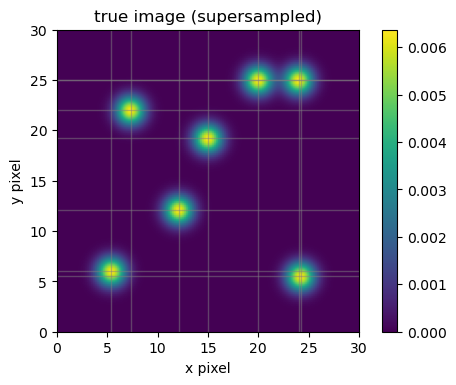

In [89]:
plot2d(Zs, spix, xcenters=xcenters, ycenters=ycenters, title="true image (supersampled)")

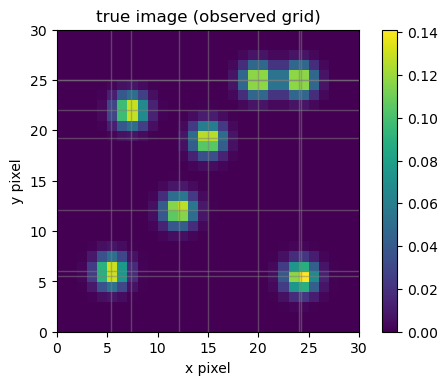

In [90]:
Z = super_to_obs(Zs)
plot2d(Z, pix, xcenters=xcenters, ycenters=ycenters, title="true image (observed grid)")

In [91]:
Zmat = jnp.dot(Smat,Zs.ravel()).reshape(Nx,Ny)
print (np.max(np.abs(Zmat-Z)))

2.7755575615628914e-17


In [92]:
np.random.seed(123)
sigmaerr = 2e-3
Zerr = np.random.randn(*np.shape(Z))*sigmaerr
Zobs = Z + Zerr

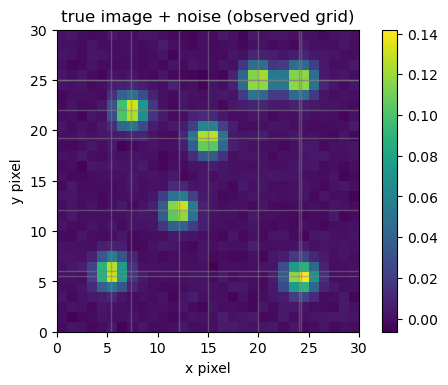

In [93]:
plot2d(Zobs, pix, xcenters=xcenters, ycenters=ycenters, title="true image + noise (observed grid)")

In [120]:
# define supersampled ePSF
xext, yext = 10., 10.
dx, dy = 1., 1.
xext, yext = 7., 7.
dx, dy = 0.5, 0.5
gpsf = GridPSFModel(xext, yext, dx, dy)
gpsfvalues = vmap(gpsf.psfvalues, (None,None,0,0,None), 0)

PSF grid shape: (15, 15)


In [121]:
# same as psfvalues when reshaped to len(X),len(Y)
def psfvalues1d(X, Y, xcenter, ycenter, params):
    values1d = gpsf.psfvalues(X, Y, xcenter, ycenter, params).ravel()
    return values1d
psfvalues1d_vmap = jit(vmap(psfvalues1d, (None,None,None,None,0), 1))
trans_matrix = jit(vmap(psfvalues1d_vmap, (None,None,0,0,None), 0))

In [122]:
#xcenter, ycenter = xcenters[0], ycenters[0]
paramseye = np.eye(gpsf.Nparams)

In [189]:
def params_to_dict(params):
    dic = {}
    c = params[:Ns]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    dic['c'] = np.array(c)
    dic['xcenters'] = np.array(xc)
    dic['ycenters'] = np.array(yc)
    dic['lnlenx'] = float(lnlenx)
    dic['lnleny']= float(lnleny)
    dic['lna'] = float(lna)
    return dic

In [588]:
Ns = len(xcenters)

def loglikelihood(params, Z1d, sigmaerr):
    #c = params[:Ns]
    c = jnp.r_[5, params[1:Ns]]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lnlenx, lnleny, lna = 1., 1., -3.
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    
    dx = gpsf.X1d[:,None] - gpsf.X1d[None,:]
    dy = gpsf.Y1d[:,None] - gpsf.Y1d[None,:]
    dx2 = jnp.power(dx / lenx, 2.0)
    dy2 = jnp.power(dy / leny, 2.0)
    kernel = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)

    Amat = c[:,None,None] * trans_matrix(spix.X, spix.Y, xc, yc, paramseye)
    print (np.shape(Amat))
    #Amat = jnp.sum(Amat, axis=0)
    Amat = jnp.dot(Smat, jnp.sum(Amat, axis=0))
    print (np.shape(Amat))
 
    cov = jnp.dot(Amat, jnp.dot(kernel, Amat.T))
    cov += sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    
    SinvZ = jnp.linalg.solve(cov, Z1d)

    #return -0.5 * len(Z1d) * jnp.linalg.slogdet(cov)[1] - 0.5 * jnp.dot(Z1d.T, SinvZ)
    return -0.5 * jnp.linalg.slogdet(cov)[1] - 0.5 * jnp.dot(Z1d.T, SinvZ)

objective = lambda p: -loglikelihood(p, Zobs.ravel(), sigmaerr)

In [589]:
import jaxopt
method = "TNC"
#method = "Nelder-Mead"
solver = jaxopt.ScipyBoundedMinimize(fun=objective, method=method)#, options={'gtol': 1e-100, 'maxfun': 10000})

In [590]:
width = 2.
params = np.array([5]*7 + list(xcenters[1:]-1.*0.5) + list(ycenters[1:]+1.*0.5) + [0+2, 0+2, 0])
params_lower = [0]*7 + list(xcenters[1:]-width) + list(ycenters[1:]-width) + [-2+2, -2+2, -10.]
params_upper = [10]*7 + list(xcenters[1:]+width) + list(ycenters[1:]+width) + [5, 5, 10.]
bounds = (params_lower, params_upper)

In [591]:
objective(params)

(7, 22500, 225)
(900, 225)


DeviceArray(-3165.27259813, dtype=float64)

In [592]:
%%time
res = solver.run(params, bounds=bounds)

(7, 22500, 225)
(900, 225)
CPU times: user 12min 38s, sys: 1min 45s, total: 14min 24s
Wall time: 3min 59s


In [593]:
res

OptStep(params=DeviceArray([ 5.        ,  5.0569377 ,  4.9442164 ,  5.04456201,
              4.99429077,  5.02219593,  4.95629275, 24.18754877,
              5.40059074,  7.29432574, 12.09673094, 20.0128784 ,
             24.00581577,  5.49720304,  5.9900924 , 22.01669853,
             12.0976582 , 24.993943  , 24.99825689,  2.        ,
              2.        ,  0.        ], dtype=float64), state=ScipyMinimizeInfo(fun_val=DeviceArray(-4868.27368075, dtype=float64), success=True, status=2, iter_num=28))

In [594]:
popt, state = res

In [595]:
pdict = params_to_dict(popt)

In [596]:
for k in pdict.keys():
    print ("%s\t%s"%(k, pdict[k]))

c	[5.         5.0569377  4.9442164  5.04456201 4.99429077 5.02219593
 4.95629275]
xcenters	[15.         24.18754877  5.40059074  7.29432574 12.09673094 20.0128784
 24.00581577]
ycenters	[19.2         5.49720304  5.9900924  22.01669853 12.0976582  24.993943
 24.99825689]
lnlenx	2.0
lnleny	2.0
lna	0.0


In [597]:
(pdict['xcenters']-xcenters)

array([ 0.        , -0.01245123,  0.00059074, -0.00567426, -0.00326906,
        0.0128784 ,  0.00581577])

In [598]:
(pdict['ycenters']-ycenters)

array([ 0.        , -0.00279696, -0.0099076 ,  0.01669853, -0.0023418 ,
       -0.006057  , -0.00174311])